In [1]:
import os
import random
import re
import pandas as pd
from openpyxl import load_workbook
from helpers import sql

In [2]:
def extract_themes(folder_path):
    data = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".xlsx") or file_name.endswith(".xlsm"):
            file_path = os.path.join(folder_path, file_name)
            workbook = load_workbook(file_path, data_only=False)

            for sheet_name in workbook.sheetnames:
                sheet = workbook[sheet_name]

                for row in sheet.iter_rows():
                    for cell in row:
                        if cell.hyperlink:
                            hyperlink = cell.hyperlink.target
                            match = re.search(r'/requests/(\d+)/', hyperlink)
                            data.append({
                                "theme": sheet_name, 
                                "id": match.group(1) if match else None
                            })

    return pd.DataFrame(data)

In [3]:
themes = extract_themes("./theme_data_verified")
themes["id"] = themes["id"].astype("int64")

In [4]:
themes['theme'].value_counts()

theme
Fisheries      170
FFHPP           32
MM              19
SAR             18
MPC             16
Aquaculture     12
AIS              6
Name: count, dtype: int64

In [5]:
def prepend_table_name(df, table_name):
    return df.rename(columns=lambda col: f"{table_name}_{col}")

csas_request = sql("SELECT * FROM csas2_csasrequest;")
section = sql("SELECT * FROM shared_models_section;")
division = sql("SELECT * FROM shared_models_division;")
branch = sql("SELECT * FROM shared_models_branch;")
sector = sql("SELECT * FROM shared_models_sector;")
region = sql("SELECT * FROM shared_models_region;")

csas_request = prepend_table_name(csas_request, "csas_request").astype('object')
csas_request['office_name'] = csas_request['csas_request_office_id'].map({
    1: 'Gulf',
    2: 'Maritimes',
    3: 'Quebec',
    6: 'Newfoundland & Labrador',
    4: 'National',
    7: 'Ontario and Prairie',
    5: 'Pacific',
    8: 'Arctic',
}) 
section = prepend_table_name(section, "section").astype('object')
division = prepend_table_name(division, "division").astype('object')
branch = prepend_table_name(branch, "branch").astype('object')
sector = prepend_table_name(sector, "sector").astype('object')
region = prepend_table_name(region, "region").astype('object')

combined_requests = (
    themes
    .merge(csas_request, left_on="id", right_on="csas_request_id", how="left", suffixes=("", "_request"))
    .merge(section, left_on="csas_request_section_id", right_on="section_id", how="left", suffixes=("", "_section"))
    .merge(division, left_on="section_division_id", right_on="division_id", how="left", suffixes=("", "_division"))
    .merge(branch, left_on="division_branch_id", right_on="branch_id", how="left", suffixes=("", "_branch"))
    .merge(sector, left_on="branch_sector_id", right_on="sector_id", how="left", suffixes=("", "_sector"))
    .merge(region, left_on="branch_region_id", right_on="region_id", how="left", suffixes=("", "_region"))
)
combined_requests = combined_requests.astype('object')

In [6]:
len(combined_requests.columns)

106

In [7]:
MIN_NON_NULL = 100
MIN_UNIQUE_VALUES = 2
MAX_UNIQUE_VALUES = 100

useful_columns = combined_requests.describe(include='all').T
useful_columns = useful_columns[(useful_columns['count'] >= MIN_NON_NULL) & (useful_columns['unique'] >= MIN_UNIQUE_VALUES) & (useful_columns['unique'] <= MAX_UNIQUE_VALUES)]
display(useful_columns)

useful_columns = list(useful_columns.index)

C:\Users\CARRK\AppData\Local\Temp\1\ipykernel_2928\1989749301.py:5: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  useful_columns = combined_requests.describe(include='all').T
C:\Users\CARRK\AppData\Local\Temp\1\ipykernel_2928\1989749301.py:5: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  useful_columns = combined_requests.describe(include='all').T
C:\Users\CARRK\AppData\Local\Temp\1\ipykernel_2928\1989749301.py:5: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, 

,count,unique,top,freq
theme,273,7,Fisheries,170
csas_request_language,272,2,1,211
csas_request_is_multiregional,232.0,2.0,0.0,155.0
csas_request_multiregional_text,270,87,,179
csas_request_advice_needed_by,272,92,2025-03-31 03:00:00,71
csas_request_has_funding,272.0,2.0,0.0,205.0
csas_request_funding_text,269,60,,193
csas_request_prioritization,254.0,3.0,1.0,156.0
csas_request_status,272,11,70,103
csas_request_section_id,272,45,123,52


In [8]:
useful_columns = [
    'theme',
    'csas_request_is_multiregional',
    # 'csas_request_office_id',
    # 'section_id',
    # 'division_id',
    # 'branch_id',
    # 'sector_id',
    # 'region_id',
    'office_name',
    'section_name',
    'division_name',
    'branch_name',
    'sector_name',
    'region_name',
]

In [9]:
df = combined_requests[useful_columns]

In [10]:
df['theme'].value_counts()

theme
Fisheries      170
FFHPP           32
MM              19
SAR             18
MPC             16
Aquaculture     12
AIS              6
Name: count, dtype: int64

In [11]:
for col in [x for x in useful_columns if x != 'theme']:
    display(df.groupby(col)['theme'].unique().reset_index())

,csas_request_is_multiregional,theme
0,0.0,"[FFHPP, Aquaculture, MM, AIS, MPC, SAR, Fisher..."
1,1.0,"[FFHPP, Aquaculture, MM, AIS, MPC, SAR, Fisher..."


,office_name,theme
0,Arctic,"[FFHPP, MM, MPC, Fisheries]"
1,Gulf,"[FFHPP, Fisheries]"
2,Maritimes,"[FFHPP, Aquaculture, MM, AIS, MPC, SAR, Fisher..."
3,National,"[FFHPP, Aquaculture, MM, AIS, MPC, SAR, Fisher..."
4,Newfoundland & Labrador,"[FFHPP, Aquaculture, AIS, MPC, SAR, Fisheries]"
5,Ontario and Prairie,"[FFHPP, AIS, SAR]"
6,Pacific,"[FFHPP, Aquaculture, MM, MPC, Fisheries]"
7,Quebec,"[Aquaculture, MM, MPC, Fisheries]"


,section_name,theme
0,Aboriginal Fisheries,"[Aquaculture, Fisheries]"
1,Aquaculture,[Aquaculture]
2,Aquaculture Directorate,[Aquaculture]
3,Aquaculture Management,[Aquaculture]
4,Aquatic Invasive Species,[AIS]
5,Aquatic Invasive Species & Species at Risk,[SAR]
6,Aquatic Invasive Species National Core Program,[AIS]
7,Ecosystem Management,[FFHPP]
8,Fish and Fish Habitat Protection Program,"[FFHPP, MM, AIS, Fisheries]"
9,Fish and Fish Habitat Protection Program and I...,[FFHPP]


,division_name,theme
0,Aquaculture Management,[Aquaculture]
1,Aquaculture Policy,[Aquaculture]
2,"Aquaculture, Biotechnology and Aquatic Animal ...",[Aquaculture]
3,Aquatic Ecosystems,"[FFHPP, MM, AIS, SAR]"
4,Aquatic Invasive Species,[AIS]
5,Aquatic Resources,[Fisheries]
6,Biodiversity Program,"[MM, SAR]"
7,Ecosystem Management,[FFHPP]
8,Ecosystems Management,"[FFHPP, Aquaculture, MM, AIS, SAR, Fisheries]"
9,Ecosystems and Fisheries Management,[Fisheries]


,branch_name,theme
0,Aquaculture Policy Directorate,[Aquaculture]
1,Aquatic Ecosystems,"[FFHPP, Aquaculture, MM, AIS, MPC, SAR, Fisher..."
2,Biodiversity Management,"[AIS, SAR]"
3,Ecosystem Management Branch,"[FFHPP, MM, AIS, SAR]"
4,Ecosystem Sciences Directorate,"[MM, SAR]"
5,Ecosystems Management,"[FFHPP, MPC]"
6,Fisheries & Harbour Management,"[MM, MPC, Fisheries]"
7,Fisheries Management,"[Aquaculture, MM, MPC, Fisheries]"
8,"Fisheries Management, Resource and Aboriginal ...",[Fisheries]
9,Fisheries Resource Management,"[MM, Fisheries]"


,sector_name,theme
0,Aquatic Ecosystems,"[FFHPP, Aquaculture, MM, AIS, MPC, SAR, Fisher..."
1,Ecosystems & Oceans Science,"[Aquaculture, MM, SAR, Fisheries]"
2,Fisheries & Harbour Management,"[Aquaculture, MM, MPC, Fisheries]"


,region_name,theme
0,Arctic,"[FFHPP, MM, MPC, Fisheries]"
1,Gulf,"[FFHPP, Fisheries]"
2,Maritimes,"[FFHPP, Aquaculture, MM, AIS, MPC, SAR, Fisher..."
3,National,"[FFHPP, Aquaculture, MM, AIS, MPC, SAR, Fisher..."
4,Newfoundland & Labrador,"[FFHPP, Aquaculture, AIS, MPC, SAR, Fisheries]"
5,Ontario and Prairie,"[FFHPP, AIS, SAR]"
6,Pacific,"[FFHPP, Aquaculture, MM, AIS, MPC, SAR, Fisher..."
7,Quebec,"[Aquaculture, MPC, Fisheries]"


In [12]:
# multiregional is useless
# division, branch, region, and sector are determined by section

useful_columns = ['theme', 'office_name', 'section_name']
df = df[useful_columns]

In [13]:
def display_theme_counts(column):
    display(
        pd.DataFrame(df[column].value_counts())
        .merge(
            df.groupby(column)['theme'].unique().reset_index(),
            on=column,
            how='inner'
        ).sort_values(column)
     )

display_theme_counts('office_name')    
display_theme_counts('section_name')

,office_name,count,theme
5,Arctic,18,"[FFHPP, MM, MPC, Fisheries]"
7,Gulf,8,"[FFHPP, Fisheries]"
0,Maritimes,69,"[FFHPP, Aquaculture, MM, AIS, MPC, SAR, Fisher..."
4,National,25,"[FFHPP, Aquaculture, MM, AIS, MPC, SAR, Fisher..."
3,Newfoundland & Labrador,25,"[FFHPP, Aquaculture, AIS, MPC, SAR, Fisheries]"
6,Ontario and Prairie,17,"[FFHPP, AIS, SAR]"
2,Pacific,42,"[FFHPP, Aquaculture, MM, MPC, Fisheries]"
1,Quebec,68,"[Aquaculture, MM, MPC, Fisheries]"


,section_name,count,theme
1,Aboriginal Fisheries,52,"[Aquaculture, Fisheries]"
19,Aquaculture,2,[Aquaculture]
11,Aquaculture Directorate,4,[Aquaculture]
13,Aquaculture Management,3,[Aquaculture]
9,Aquatic Invasive Species,4,[AIS]
22,Aquatic Invasive Species & Species at Risk,1,[SAR]
20,Aquatic Invasive Species National Core Program,1,[AIS]
24,Ecosystem Management,1,[FFHPP]
2,Fish and Fish Habitat Protection Program,29,"[FFHPP, MM, AIS, Fisheries]"
16,Fish and Fish Habitat Protection Program and I...,2,[FFHPP]


# decision tree

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [15]:
X = pd.get_dummies(df.drop(columns=['theme']), drop_first=True).astype(bool)  # Force dtype to bool after get_dummies
y = df['theme']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

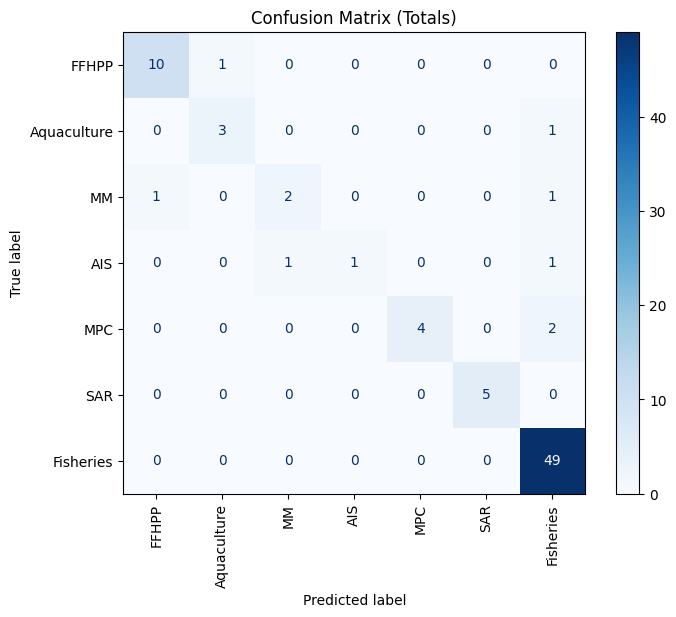

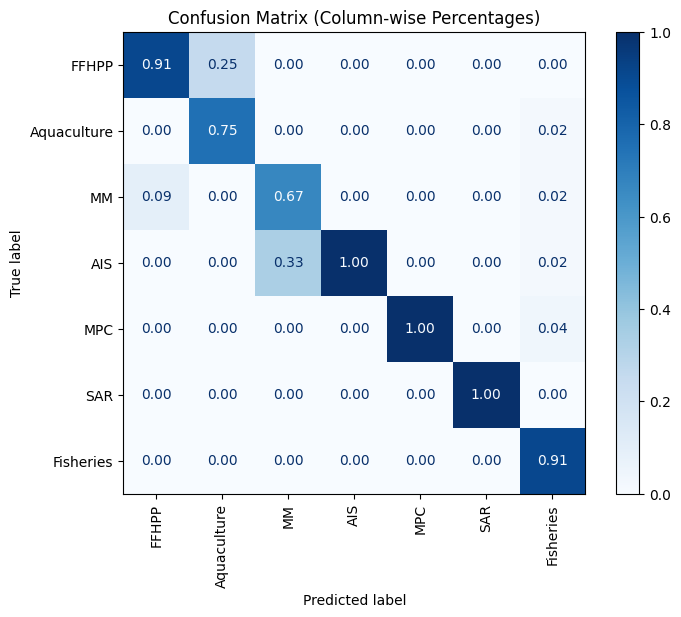

In [17]:
cm = confusion_matrix(y_test, y_pred, labels=y.unique())

cm_total = cm.astype('float')

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_total, display_labels=y.unique())
disp.plot(cmap='Blues', ax=plt.gca(), values_format=".0f")

ax = plt.gca()
ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.grid(False)

plt.title("Confusion Matrix (Totals)")
plt.show()

cm_percentage = cm.astype('float') / cm.sum(axis=0)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=y.unique())
disp.plot(cmap='Blues', ax=plt.gca(), values_format=".2f")

ax = plt.gca()
ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.grid(False)

plt.title("Confusion Matrix (Column-wise Percentages)")
plt.show()

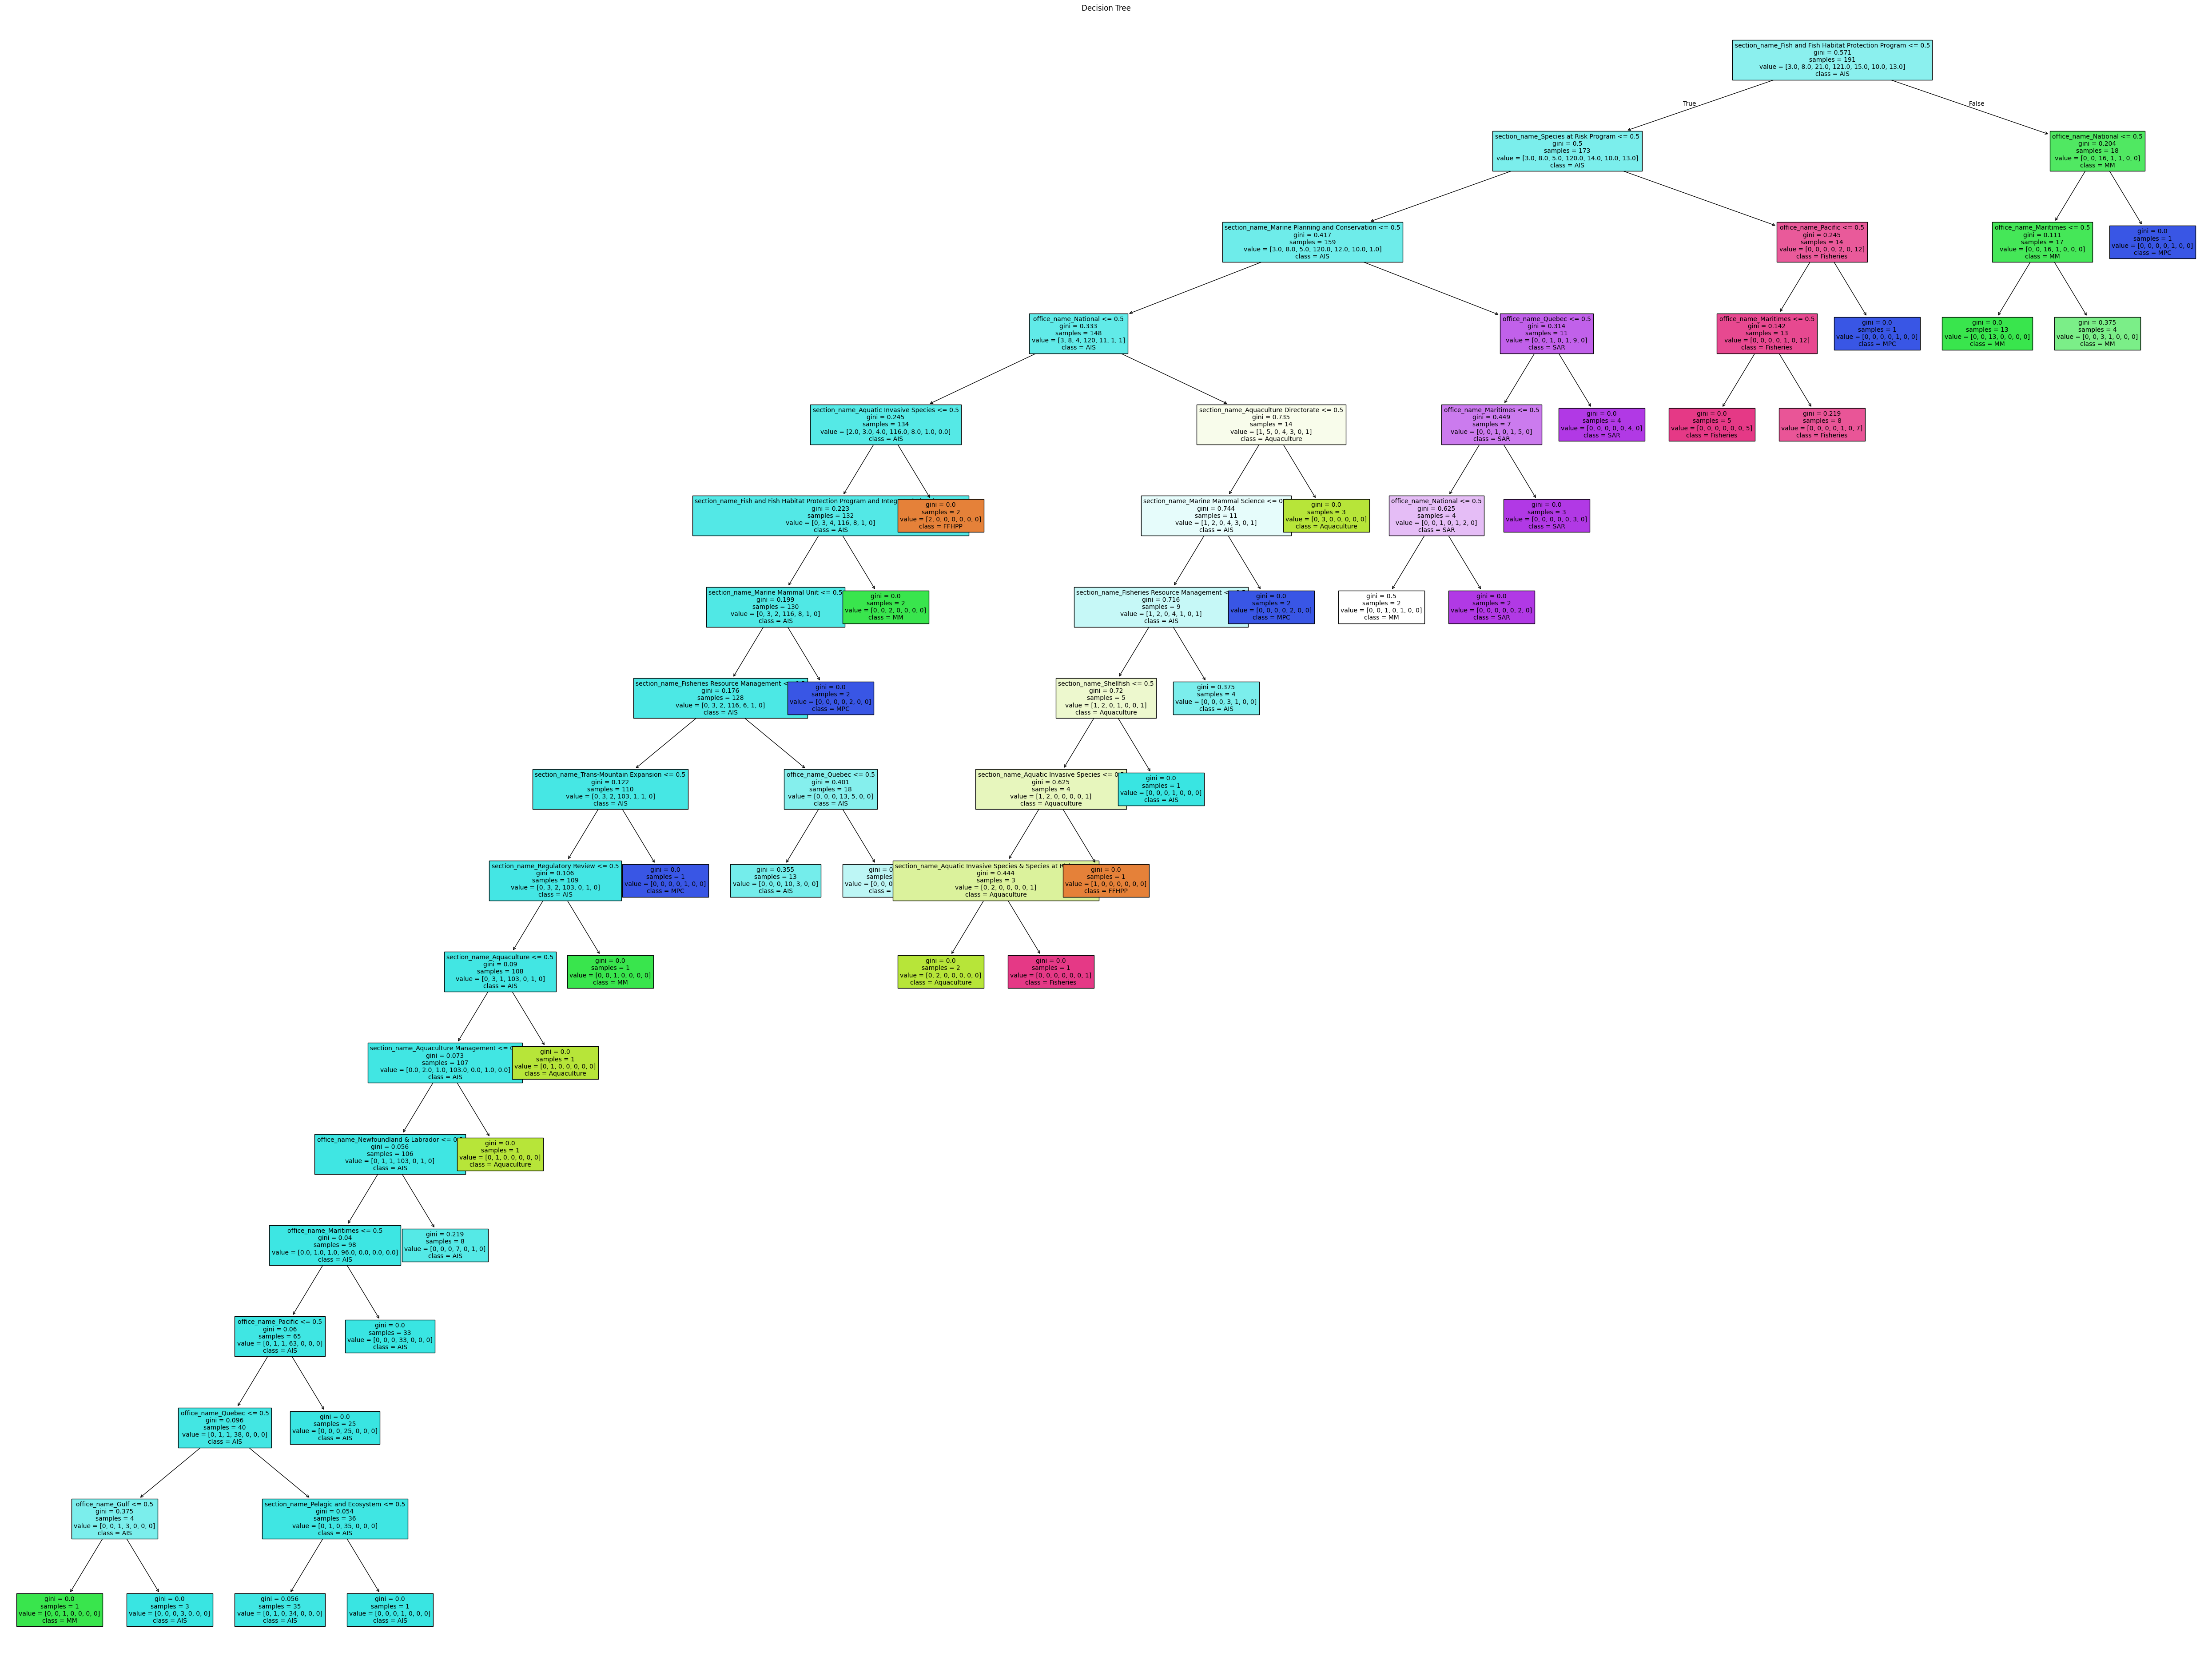

In [18]:
plt.figure(figsize=(64, 48))
plot_tree(clf, feature_names=X_train.columns, class_names=y.unique().astype(str), filled=True, fontsize=10)
plt.title("Decision Tree")
plt.show()

# simple prediction algorithm allowing ambiguity

In [19]:
themes_by_section = df.groupby('section_name')['theme'].unique().apply(list).to_dict()
themes_by_office = df.groupby('office_name')['theme'].unique().apply(list).to_dict()

sections = list(themes_by_section.keys())
offices = list(themes_by_office.keys())

def predicted_theme(section_name, office_name):
    return [x for x in themes_by_section[section_name] if x in themes_by_office[office_name]]

In [20]:
# check random choice to see prediction
random_section, random_office = random.choice(sections), random.choice(offices)

print(f"{random_section=}\n{random_office=}\npredicted theme(s):\n\n{predicted_theme(random_section, random_office)=}")

random_section='Aquatic Invasive Species National Core Program'
random_office='Quebec'
predicted theme(s):

predicted_theme(random_section, random_office)=[]


In [21]:
n_ambiguous, n_missing, n_distinct = 0, 0, 0

for s in sections:
    for o in offices:
        lst = predicted_theme(s, o)
        if len(lst) == 0:
            n_missing += 1
        elif len(lst) > 1:
            n_ambiguous += 1
        elif len(lst) == 1:
            n_distinct += 1
        else:
            print(f"ERROR: {s=} {o=}")
            
print(f"{n_ambiguous=}, {n_missing=}, {n_distinct=}")

n_ambiguous=33, n_missing=51, n_distinct=148
